In [308]:
using StatsBase, StatsFuns, Distributions, PyPlot, JuMP, Gurobi
n= 100;
Y = rand(Exponential(1),n);
#Y = rand(Exponential(1),n);
#Y = rand(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-1.0, 1)], [0.3, 0.7]), n);

In [309]:
a = 0
b = 10
m = 10 + 1

M = Model(solver = GurobiSolver())

@variable(M, 0<=w[1:m]<=1)
@constraint(M, sum(w)==1);

In [310]:
# Monotonicity
for i=1:m-1
    @constraint(M, w[i+1]<=w[i])
end
# Convexity
for i=2:m-1
    @constraint(M, 2*w[i]<=w[i-1]+w[i+1])
end

In [311]:
ϵ = 3/(8*n)
Ecdf = ecdf(Y)

L = zeros(n,n)
B = zeros(n,m)
f = zeros(n,1)
for i = 1:n 
    L[i,i] = (n/((Ecdf(Y[i])+ϵ)*(1+ϵ-Ecdf(Y[i]))))^0.5 
    f[i] = Ecdf(Y[i])
end
for i=1:n
    for j=1:m
        B[i,j] = betacdf(j, m-j+1, (Y[i]-a)/(b-a))
    end
end

@variable(M, r[1:n])
@constraint(M, r.==L*(f-B*w))
 
@objective(M, Min, sum(r.^2))
#@objective(M, Min, sum(w'*(B'*L*B)*w-2*f'*L*B*w+f'*L*f))

:Min

In [312]:
tic()
solve(M)
toc()

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Optimize a model with 120 rows, 111 columns and 1137 nonzeros
Model has 100 quadratic objective terms
Coefficient statistics:
  Matrix range    [1e-13, 2e+02]
  Objective range [0e+00, 0e+00]
  Bounds range    [1e+00, 1e+00]
  RHS range       [9e-01, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.00s
Presolved: 120 rows, 111 columns, 1013 nonzeros
Presolved model has 100 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Dense cols : 11
 AA' NZ     : 9.130e+02
 Factor NZ  : 1.099e+03
 Factor Ops : 1.046e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.37112733e+04 -2.85733670e+06  1.10e+04 1.00e+03  8.39e+05     0s
   1   4.19339849e+06 -5.26108067e+06  1.73e+03 1.57e+

0.007152593

In [313]:
w_hat=getvalue(w)
D = 1000;
x = linspace(a,b,D);
y1 = zeros(D,1);
y1 = y1[:,1];
y2 = zeros(D,1);
y2 = y2[:,1];

for i = 1:D
    #y1[i] = pdf(MixtureModel(Normal[Normal(2.0, 1.0),Normal(-1.0, 1)], [0.3, 0.7]),x[i]);
    y1[i] = exp(-x[i])
    for j = 1:m
        y2[i] = y2[i]+w_hat[j]*betapdf(j, m-j+1, (x[i]-a)/(b-a))/(b-a);
    end
end

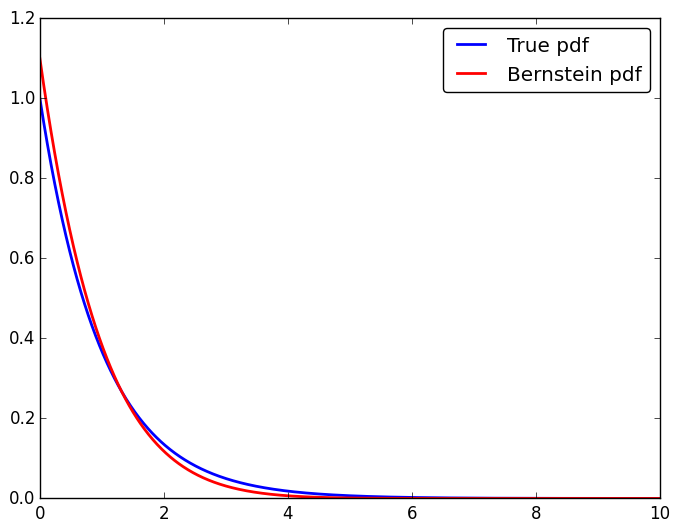

PyObject <matplotlib.legend.Legend object at 0x000000005B709978>

In [314]:
plot(x, y1, color="blue", linewidth=2.0, label="True pdf")
plot(x, y2, color="red", linewidth=2.0, label="Bernstein pdf")
legend(loc="upper right",fancybox="true")

In [315]:
mean(abs(y1-y2))

0.011316303230839138